In [1]:
using LinearAlgebra, CairoMakie

In [2]:
# Averaging kernel a la shchepetkin
function low_dispersion_filter(τ::T; p=2, q=4, r=0.18927) where T 
    τ₀ = (p + 2) * (p + q + 2) / (p + 1) / (p + q + 1)
    return (τ / τ₀)^p * (1 - (τ / τ₀)^q) - r * (τ / τ₀)
end

cosine_filter(τ::T) where T = τ ≥ 0.5 && τ ≤ 1.5 ? convert(T, 1 + cos(2π * (τ - 1))) : zero(T)
constant_filter(τ::T) where T = convert(T, 1)
no_filter(τ::T) where T = τ == 2 ? 1 : 0

no_filter (generic function with 1 method)

In [3]:
# Computing the weights from substeps, almost same function as is 
# https://github.com/CliMA/Oceananigans.jl/blob/cce1928ebb3d428701296aafb338fb3874dfed36/src/Models/HydrostaticFreeSurfaceModels/SplitExplicitFreeSurfaces/split_explicit_free_surface.jl#L300
function weights_from_substeps(substeps::Int, averaging_kernel::Function)
    M = substeps ÷ 2
    τᶠ = range(0.0, 2.0, length=substeps+1)
    Δτ = τᶠ[2] - τᶠ[1]
    
    averaging_weights = [averaging_kernel(τ) for τ in τᶠ[2:end]]
    
    # Find M* (latest allowable weight)
    M★ = substeps
    for i in substeps:-1:1
        if averaging_weights[i] > 0
            M★ = i
            break
        end
    end
    
    averaging_weights[M★+1:substeps] .= zero(eltype(averaging_weights))
    averaging_weights ./= sum(averaging_weights)
    transport_weights = [sum(averaging_weights[i:end]) for i in 1:substeps] ./ M

    return Δτ, averaging_weights, transport_weights
end

weights_from_substeps (generic function with 1 method)

## Parameters 
parameters used to compute the evolution matrices
typical parameters found in ocean simulations

In [4]:
### Physical parameters
g = 9.81    # m/s²
H = 6000.0  # m
N² = 1e-4   # s⁻² (typical ocean stratification)

# Wavenumbers
Δx = 7812.0       # m (grid spacing)
k  = 1 / Δx      # barotropic wavenumber
c0 = sqrt(g * H)

# Parameters for timestepping
Δt_max = 100 / c0 / k / 2

# Parameters used for the split-explicit computation
NS = 20
averaging_kernel = low_dispersion_filter

# types for dispatch
struct Implicit1 end
struct Implicit2 end
struct SplitExplicit1 end
struct SplitExplicit2 end

## Evolution matrices for Split-Explicit with $w^p = w^m$

In [5]:
function compute_A(::SplitExplicit1, γ, k, g, N², H, ψ, ψ2=ψ; NS=NS, averaging_kernel=averaging_kernel)
    A = zeros(ComplexF64, 4, 4)
    ℂ = zeros(ComplexF64, 2, 2)

    Δτ, w, t = weights_from_substeps(NS, averaging_kernel)
    γB = γ * Δτ 

    c² = N² * H^2 / π^2
    C  = γ * c² / g

    ℂ[1,1] = 1
    ℂ[1,2] = - γB * g * im * k  
    ℂ[2,1] = - γB * H * im * k  
    ℂ[2,2] = 1 - γB^2 * g * k^2 * H  

    ABT = sum([w[i]*ℂ^i for i in 1:NS])

    A[1,1] = ABT[1,1]
    A[1,2] = ABT[1,2]
    A[1,4] = ABT[1,2] * ψ    
    A[2,1] = ABT[2,1] 
    A[2,2] = ABT[2,2] 
    A[2,4] = ABT[2,2] * ψ - ψ 
    A[3,3] = 1.0
    A[4,4] = 1.0
    
    return A
end

function compute_B(::SplitExplicit1, γ, k, g, N², H, ψ, ψ2=ψ; NS=NS, averaging_kernel=averaging_kernel)
    B = zeros(ComplexF64, 4, 4)
    ℂ = zeros(ComplexF64, 2, 2)
    D = zeros(ComplexF64, 2, 2)
    
    Δτ, w, t = weights_from_substeps(NS, averaging_kernel)
    γB = γ * Δτ 

    c² = N² * H^2 / π^2
    C  = γ * c² / g

    ℂ[1,1] = 1
    ℂ[1,2] = - γB * g * im * k  
    ℂ[2,1] = - γB * H * im * k  
    ℂ[2,2] = 1 - γB^2 * g * k^2 * H  
    D[1,2] = γB * im * k * g * ψ
    D[2,2] = γB^2 * k^2 * g * H * ψ
    
    BBT = sum([w[i]*sum([ℂ^s*D for s in 0:i-1]) for i in 1:NS])

    B[1,4] = BBT[1,2]
    B[2,1] = - im * k * C * ψ * ψ2
    B[2,3] = im * k * C * ψ
    B[2,4] = BBT[2,2] 
    B[3,4] = - γ * g * im * k 
    B[4,1] = im * k * C * ψ2
    B[4,3] = -im * k * C 
    
    return B
end

compute_B (generic function with 2 methods)

## Evolution matrices for Split-Explicit with $w^p = w^\star$

In [6]:
function compute_A(::SplitExplicit2, γ, k, g, N², H, ψ, ψ2=ψ; NS=NS, averaging_kernel=averaging_kernel)
    A = zeros(ComplexF64, 4, 4)
    ℂ = zeros(ComplexF64, 2, 2)

    Δτ, w, t = weights_from_substeps(NS, averaging_kernel)
    γB = γ * Δτ 

    c² = N² * H^2 / π^2
    C  = γ * c² / g

    ℂ[1,1] = 1
    ℂ[1,2] = - γB * g * im * k  
    ℂ[2,1] = - γB * H * im * k  
    ℂ[2,2] = 1 - γB^2 * g * k^2 * H  

    ABT = sum([w[i]*ℂ^i for i in 1:NS])
    ÃBT = sum([t[i]*ℂ^i for i in 1:NS])

    A[1,1] = ABT[1,1]
    A[1,2] = ABT[1,2]
    A[1,4] = ABT[1,2] * ψ    
    A[2,1] = ABT[2,1] - im * k * C * ψ * ψ2 * ÃBT[1,1]
    A[2,2] = ABT[2,2] - im * k * C * ψ * ψ2 * ÃBT[1,2]
    A[2,4] = ABT[2,2] * ψ - ψ - im * k * C * ψ^2 * ψ2 * ÃBT[1,2]
    A[3,3] = 1.0
    A[4,1] = im * k * C * ψ2 * ÃBT[1,1]
    A[4,2] = im * k * C * ψ2 * ÃBT[1,2]
    A[4,4] = 1.0 + im * k * C * ψ * ψ2 * ÃBT[1,2]
    
    return A
end

function compute_B(::SplitExplicit2, γ, k, g, N², H, ψ, ψ2=ψ; NS=NS, averaging_kernel=averaging_kernel)
    B = zeros(ComplexF64, 4, 4)
    ℂ = zeros(ComplexF64, 2, 2)
    D = zeros(ComplexF64, 2, 2)
    
    Δτ, w, t = weights_from_substeps(NS, averaging_kernel)
    γB = γ * Δτ 

    c² = N² * H^2 / π^2
    C  = γ * c² / g

    ℂ[1,1] = 1
    ℂ[1,2] = - γB * g * im * k  
    ℂ[2,1] = - γB * H * im * k  
    ℂ[2,2] = 1 - γB^2 * g * k^2 * H  
    D[1,2] = γB * im * k * g * ψ
    D[2,2] = γB^2 * k^2 * g * H * ψ
    
    BBT = sum([w[i]*sum([ℂ^s*D for s in 0:i-1]) for i in 1:NS])
    B̃BT = sum([t[i]*sum([ℂ^s*D for s in 0:i-1]) for i in 1:NS])

    B[1,4] = BBT[1,2]
    B[2,3] = im * k * C * ψ
    B[2,4] = BBT[2,2] - im * k * C * ψ * ψ2 * B̃BT[1,2]
    B[3,4] = - γ * g * im * k 
    B[4,3] = -im * k * C 
    B[4,4] = im * k * C * ψ2 * B̃BT[1,2]
    
    return B
end

compute_B (generic function with 4 methods)

## Evolution matrices for Implicit with $w^p = w^m$

In [7]:
function compute_A(::Implicit1, γ, k, g, N², H, ψ, ψ2=ψ)
    A = zeros(ComplexF64, 4, 4)
    D = 1 + γ^2 * g * H * k^2
        
    A[1,1] = 1 / D
    A[1,2] = - γ * g * im * k / D
    A[1,4] = - γ * g * im * k * ψ / D
    A[2,1] = - γ * H * im * k / D
    A[2,2] = 1 / D
    A[2,4] = - ψ * (D - 1) / D
    A[3,3] = 1.0
    A[4,4] = 1.0
    
    return A
end

function compute_B(::Implicit1, γ, k, g, N², H, ψ, ψ2=ψ)
    B = zeros(ComplexF64, 4, 4)
    D = 1 + γ^2 * g * H * k^2
    
    c² = N² * H^2 / π^2
    C  = γ * c² / g
    
    B[1,4] = γ * g * im * k * ψ / D
    B[2,1] = -im * k * C * ψ * ψ2
    B[2,3] =  im * k * C * ψ
    B[2,4] = ψ * (D - 1) / D
    B[3,4] = - γ * g * im * k 
    B[4,1] =  im * k * C * ψ2
    B[4,3] = -im * k * C 
    
    return B
end

compute_B (generic function with 6 methods)

## Evolution matrices for Implicit with $w^p = w^\star$

In [8]:
function compute_A(::Implicit2, γ, k, g, N², H, ψ, ψ2=ψ)
    A  = zeros(ComplexF64, 4, 4)
    D  = 1 + γ^2 * g * H * k^2
    c² = N² * H^2 / π^2
    C  = γ * c² / g
    D2 = 1 + γ * g * k^2 * ψ * ψ2 * C

    A[1,1] = 1 / D
    A[1,2] = - γ * g * im * k / D
    A[1,4] = - γ * g * im * k * ψ / D
    A[2,1] = - (γ * H * im * k + im * k * C * ψ2 * ψ) / D
    A[2,2] = (2 - D2) / D
    A[2,4] = ψ * (2 - D2 - D) / D
    A[3,3] = 1.0
    A[4,1] = (im * k * C * ψ2) / D
    A[4,2] = - (γ * g * k^2 * C * ψ2) / D
    A[4,4] = 1.0 + (D2 - 1) / D
    
    return A
end

function compute_B(::Implicit2, γ, k, g, N², H, ψ, ψ2=ψ)
    B  = zeros(ComplexF64, 4, 4)
    D  = 1 + γ^2 * g * H * k^2
    c² = N² * H^2 / π^2
    C  = γ * c² / g
    D2 = 1 + γ * g * k^2 * ψ * ψ2 * C

    B[1,4] = γ * g * im * k * ψ / D
    B[2,3] =  im * k * C * ψ
    B[2,4] = ψ * (D + D2 - 2) / D
    B[3,4] = - γ * g * im * k 
    B[4,3] = -im * k * C 
    B[4,4] = (1 - D2) / D
    
    return B
end

compute_B (generic function with 8 methods)

## Generic evolution matrices

In [9]:
function compute_evolution_matrix(::Val{2}, free_surface, Δt, k, g, N², H; ψ = sqrt(2.0), ψ2 = ψ)
    γ₁ = Δt / 2
    A1 = compute_A(free_surface, γ₁, k, g, N², H, ψ, ψ2)
    B1 = compute_B(free_surface, γ₁, k, g, N², H, ψ, ψ2)

    γ₂ = Δt
    A2 = compute_A(free_surface, γ₂, k, g, N², H, ψ, ψ2)
    B2 = compute_B(free_surface, γ₂, k, g, N², H, ψ, ψ2)
    
    return A2 +
           B2 * A1 +
           B2 * B1
end
    
function compute_evolution_matrix(::Val{3}, free_surface, Δt, k, g, N², H; ψ = sqrt(2.0), ψ2 = ψ)  
    γ₁ = Δt / 3
    A1 = compute_A(free_surface, γ₁, k, g, N², H, ψ, ψ2)
    B1 = compute_B(free_surface, γ₁, k, g, N², H, ψ, ψ2)
    
    γ₂ = Δt / 2
    A2 = compute_A(free_surface, γ₂, k, g, N², H, ψ, ψ2)
    B2 = compute_B(free_surface, γ₂, k, g, N², H, ψ, ψ2)

    γ₃ = Δt
    A3 = compute_A(free_surface, γ₃, k, g, N², H, ψ, ψ2)
    B3 = compute_B(free_surface, γ₃, k, g, N², H, ψ, ψ2)
    
    return A3 +
           B3 * A2 +
           B3 * B2 * A1 +
           B3 * B2 * B1
end

function compute_evolution_matrix(::Val{4}, free_surface, Δt, k, g, N², H; ψ = sqrt(2.0), ψ2 = ψ)    
    γ₁ = Δt / 4
    A1 = compute_A(free_surface, γ₁, k, g, N², H, ψ, ψ2)
    B1 = compute_B(free_surface, γ₁, k, g, N², H, ψ, ψ2)
    
    γ₂ = Δt / 3
    A2 = compute_A(free_surface, γ₂, k, g, N², H, ψ, ψ2)
    B2 = compute_B(free_surface, γ₂, k, g, N², H, ψ, ψ2)

    γ₃ = Δt / 2
    A3 = compute_A(free_surface, γ₃, k, g, N², H, ψ, ψ2)
    B3 = compute_B(free_surface, γ₃, k, g, N², H, ψ, ψ2)
    
    γ₄ = Δt 
    A4 = compute_A(free_surface, γ₄, k, g, N², H, ψ, ψ2)
    B4 = compute_B(free_surface, γ₄, k, g, N², H, ψ, ψ2)
    
    return A4 +
           B4 * A3 +
           B4 * B3 * A2 +
           B4 * B3 * B2 * A1 +       
           B4 * B3 * B2 * B1 
end

compute_evolution_matrix (generic function with 3 methods)

In [10]:
function amplification_factor(Δt_range, k, g, N², H, free_surface; order=Val(3), ψ = sqrt(2.0), ψ2 = ψ)
    λmax = Float64[]
    λmin = Float64[]
    for Δt in Δt_range
        M  = compute_evolution_matrix(order, free_surface, Δt, k, g, N², H; ψ, ψ2)
        λ  = eigvals(M)
        λa = abs.(λ)
        push!(λmax, maximum(λa))
        push!(λmin, minimum(λa))
    end

    return λmax, λmin
end

amplification_factor (generic function with 1 method)

## Plotting amplification factors for the three methods

In [11]:
Δt_range = range(0.1, Δt_max, length=1000)
cfl = Δt_range .* c0 .* k 

0.00310561699218982:0.05004694132433214:50.00000000000001

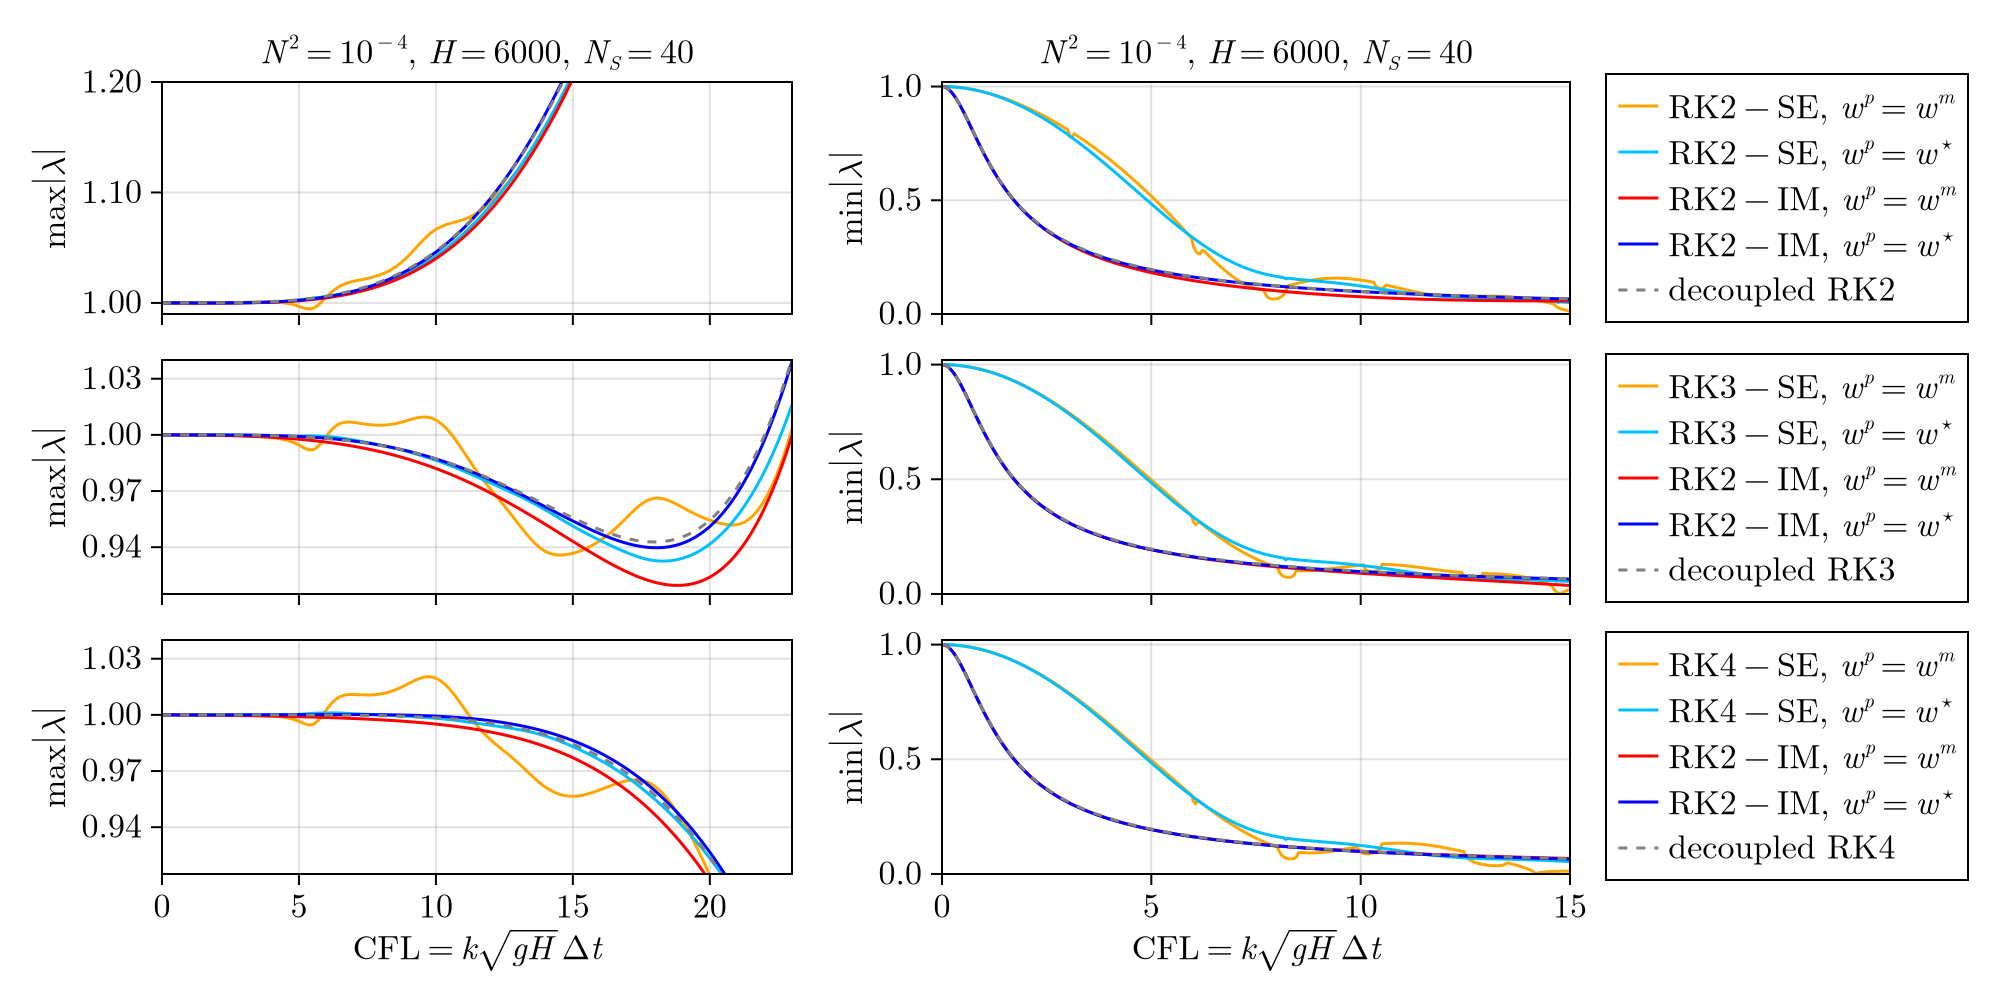

CairoMakie.Screen{IMAGE}


In [12]:
c1 = :deepskyblue 
c3 = :blue
c4 = :orange
c2 = :red

NS = 40
N² = 1e-4
H  = 6000

# If we integrate in depth the buoyancy equation, rather than project on Φ(z), 
# comment this line and uncomment the following:
ψ  = - sqrt(2)
ψ2 = π^2 / ψ / 4

λmxS1, λmnS1 = amplification_factor(Δt_range, k, g, N², H, SplitExplicit1(); order=Val(2), ψ, ψ2)
λmxS2, λmnS2 = amplification_factor(Δt_range, k, g, N², H, SplitExplicit2(); order=Val(2), ψ, ψ2)
λmxI1, λmnI1 = amplification_factor(Δt_range, k, g, N², H, Implicit1();      order=Val(2), ψ, ψ2)
λmxI2, λmnI2 = amplification_factor(Δt_range, k, g, N², H, Implicit2();      order=Val(2), ψ, ψ2)
λmxZr, λmnZr = amplification_factor(Δt_range, k, g, N², H, Implicit1();      order=Val(2), ψ=0, ψ2=0)

fig = Figure(size = (1000, 500), fontsize=17)
ax1 = Axis(fig[1, 1], 
           title = L"N^2=10^{-4}, \ H=6000, \ N_S=40", 
           ylabel = L"\text{max}\left|\lambda\right|", 
           xticks = ([0, 5, 10, 15, 20], ["", "", "", "", ""]),
           yticks = ([1.0, 1.1, 1.2], [L"1.00", L"1.10", L"1.20"]))

lines!(ax1, cfl, λmxS1, color=c4)
lines!(ax1, cfl, λmxS2, color=c1)
lines!(ax1, cfl, λmxI1, color=c2)
lines!(ax1, cfl, λmxI2, color=c3)
lines!(ax1, cfl, λmxZr, color=:grey, linestyle=:dash)
xlims!(ax1, 0, 23)
ylims!(ax1, 0.99, 1.2)

ax1 = Axis(fig[1, 2], 
           title = L"N^2=10^{-4}, \ H=6000, \ N_S=40", 
           ylabel = L"\text{min}\left|\lambda\right|", 
           xticks = ([0, 5, 10, 15, 20], ["", "", "", "", ""]),
           yticks = ([0, 0.5, 1.0], [L"0.0", L"0.5", L"1.0"]))

lines!(ax1, cfl, λmnS1, color=c4, label=L"\text{RK2-SE, }w^p=w^m")
lines!(ax1, cfl, λmnS2, color=c1, label=L"\text{RK2-SE, }w^p=w^\star")
lines!(ax1, cfl, λmnI1, color=c2, label=L"\text{RK2-IM, }w^p=w^m")
lines!(ax1, cfl, λmnI2, color=c3, label=L"\text{RK2-IM, }w^p=w^\star")
lines!(ax1, cfl, λmnZr, color=:grey, linestyle=:dash, label=L"\text{decoupled RK2}")
xlims!(ax1, 0, 15)
ylims!(ax1, 0, 1.02)
Legend(fig[1, 3], ax1)

λmxS1, λmnS1 = amplification_factor(Δt_range, k, g, N², H, SplitExplicit1(); order=Val(3), ψ, ψ2)
λmxS2, λmnS2 = amplification_factor(Δt_range, k, g, N², H, SplitExplicit2(); order=Val(3), ψ, ψ2)
λmxI1, λmnI1 = amplification_factor(Δt_range, k, g, N², H, Implicit1();      order=Val(3), ψ, ψ2)
λmxI2, λmnI2 = amplification_factor(Δt_range, k, g, N², H, Implicit2();      order=Val(3), ψ, ψ2)
λmxZr, λmnZr = amplification_factor(Δt_range, k, g, N², H, Implicit1();      order=Val(3), ψ=0, ψ2=0)

ax1 = Axis(fig[2, 1], 
           ylabel = L"\text{max}\left|\lambda\right|",
           xticks = ([0, 5, 10, 15, 20], ["", "", "", "", ""]),
           yticks = ([0.94, 0.97, 1.0, 1.03], [L"0.94", L"0.97", L"1.00", L"1.03"]))

lines!(ax1, cfl, λmxS1, color=c4)
lines!(ax1, cfl, λmxS2, color=c1)
lines!(ax1, cfl, λmxI1, color=c2)
lines!(ax1, cfl, λmxI2, color=c3)
lines!(ax1, cfl, λmxZr, color=:grey, linestyle=:dash)
xlims!(ax1, 0, 23)
ylims!(ax1, 0.915, 1.04)

ax1 = Axis(fig[2, 2], 
           ylabel = L"\text{min}\left|\lambda\right|", 
           xticks = ([0, 5, 10, 15, 20], ["", "", "", "", ""]),
           yticks = ([0, 0.5, 1.0], [L"0.0", L"0.5", L"1.0"]))

lines!(ax1, cfl, λmnS1, color=c4, label=L"\text{RK3-SE, }w^p=w^m")
lines!(ax1, cfl, λmnS2, color=c1, label=L"\text{RK3-SE, }w^p=w^\star")
lines!(ax1, cfl, λmnI1, color=c2, label=L"\text{RK2-IM, }w^p=w^m")
lines!(ax1, cfl, λmnI2, color=c3, label=L"\text{RK2-IM, }w^p=w^\star")
lines!(ax1, cfl, λmnZr, color=:grey, linestyle=:dash, label=L"\text{decoupled RK3}")
xlims!(ax1, 0, 15)
ylims!(ax1, 0, 1.02)
Legend(fig[2, 3], ax1)

λmxS1, λmnS1 = amplification_factor(Δt_range, k, g, N², H, SplitExplicit1(); order=Val(4), ψ, ψ2)
λmxS2, λmnS2 = amplification_factor(Δt_range, k, g, N², H, SplitExplicit2(); order=Val(4), ψ, ψ2)
λmxI1, λmnI1 = amplification_factor(Δt_range, k, g, N², H, Implicit1();      order=Val(4), ψ, ψ2)
λmxI2, λmnI2 = amplification_factor(Δt_range, k, g, N², H, Implicit2();      order=Val(4), ψ, ψ2)
λmxZr, λmnZr = amplification_factor(Δt_range, k, g, N², H, Implicit1();      order=Val(4), ψ=0, ψ2=0)

ax1 = Axis(fig[3, 1], 
           ylabel = L"\text{max}\left|\lambda\right|",
           xlabel = L"\text{CFL} = k\sqrt{gH}\Delta t", 
           xticks = ([0, 5, 10, 15, 20], [L"0", L"5", L"10", L"15", L"20"]),
           yticks = ([0.94, 0.97, 1.0, 1.03], [L"0.94", L"0.97", L"1.00", L"1.03"]))

lines!(ax1, cfl, λmxS1, color=c4)
lines!(ax1, cfl, λmxS2, color=c1)
lines!(ax1, cfl, λmxI1, color=c2)
lines!(ax1, cfl, λmxI2, color=c3)
lines!(ax1, cfl, λmxZr, color=:grey, linestyle=:dash)
xlims!(ax1, 0, 23)
ylims!(ax1, 0.915, 1.04)

ax1 = Axis(fig[3, 2], 
           ylabel = L"\text{min}\left|\lambda\right|", 
           xlabel = L"\text{CFL} = k\sqrt{gH}\Delta t", 
           xticks = ([0, 5, 10, 15, 20], [L"0", L"5", L"10", L"15", L"20"]),
           yticks = ([0, 0.5, 1.0], [L"0.0", L"0.5", L"1.0"]))

lines!(ax1, cfl, λmnS1, color=c4, label=L"\text{RK4-SE, }w^p=w^m")
lines!(ax1, cfl, λmnS2, color=c1, label=L"\text{RK4-SE, }w^p=w^\star")
lines!(ax1, cfl, λmnI1, color=c2, label=L"\text{RK2-IM, }w^p=w^m")
lines!(ax1, cfl, λmnI2, color=c3, label=L"\text{RK2-IM, }w^p=w^\star")
lines!(ax1, cfl, λmnZr, color=:grey, linestyle=:dash, label=L"\text{decoupled RK4}")
xlims!(ax1, 0, 15)
ylims!(ax1, 0, 1.02)
Legend(fig[3, 3], ax1)

path = "/Users/simonesilvestri/Dropbox (MIT)/Apps/Overleaf/timestepper/"
save(path * "linear-stability-combined.pdf", fig)
display(fig)